- Problem Statement: We aim to predict customer attrition (churn) for ABC Bank. In banking, retaining a customer is 5-7 times cheaper than acquiring a new one. Our goal is to identify high-risk customers before they leave.

- Solution Approach: We handled data imbalance using SMOTE. We engineered 4 domain-specific features. We compared a baseline Logistic Regression with more complex models (RF, SVM, KNN) using Stratified Cross-Validation to ensure robustness.

- Key Insight: While Random Forest is the most accurate, SVM offers the best Recall. From a business perspective, Recall is our priority because we want to capture as many potential churners as possible, even at the cost of some false alarms.

Predicting customer churn is a classic binary classification problem in finance. Our target variable is 'churn' (1 for left, 0 for stayed)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

df = pd.read_csv('data/raw/Bank Customer Churn Prediction.csv')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Initial data inspection

In [4]:
print("Data Structure:")
print(f"\nDataset dimensions: {df.shape[0]} rows × {df.shape[1]} columns")
print("\nColumn names and types:")
print(df.dtypes)
print("\nDataset info:")
df.info()

Data Structure:

Dataset dimensions: 10000 rows × 12 columns

Column names and types:
customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_numb

### Missing Values Analysis

In [6]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percentage
})
print(missing_df[missing_df['Missing Count'] > 0])

if missing_df['Missing Count'].sum() == 0:
    print("\n No missing values found")

Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []

 No missing values found


### Target Variable Analysis


Churn distribution:
Not churned (0): 7963 (79.63%)
Churned (1): 2037 (20.37%)

Class imbalance ratio: 3.91:1


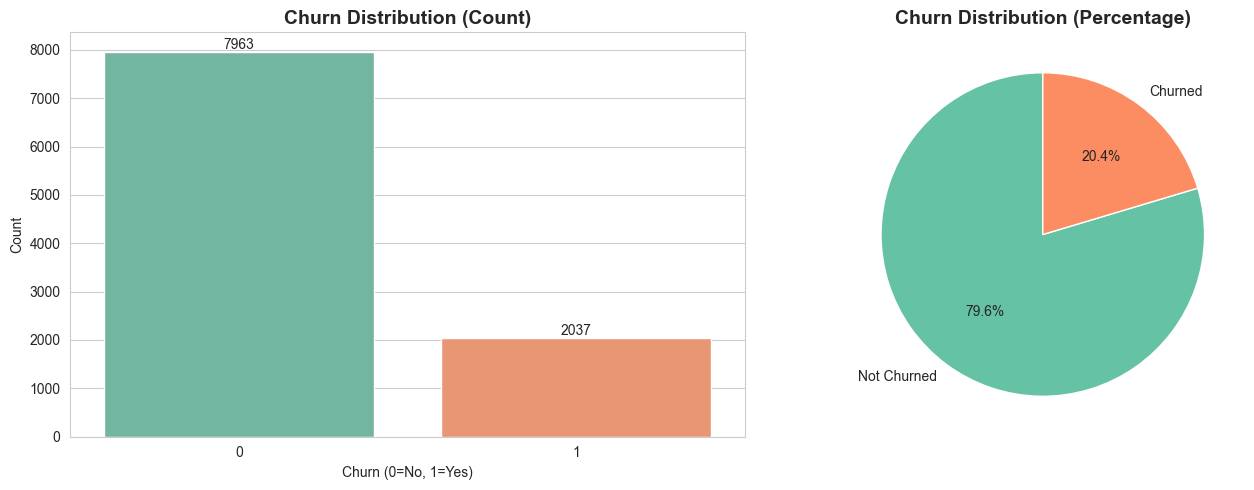

In [7]:
churn_counts = df['churn'].value_counts()
churn_percentage = df['churn'].value_counts(normalize=True) * 100

print("\nChurn distribution:")
print(f"Not churned (0): {churn_counts[0]} ({churn_percentage[0]:.2f}%)")
print(f"Churned (1): {churn_counts[1]} ({churn_percentage[1]:.2f}%)")
print(f"\nClass imbalance ratio: {churn_counts[0]/churn_counts[1]:.2f}:1")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='churn', ax=axes[0], palette='Set2')
axes[0].set_title('Churn Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn (0=No, 1=Yes)')
axes[0].set_ylabel('Count')
for container in axes[0].containers:
    axes[0].bar_label(container)

# Percentage plot
axes[1].pie(churn_counts, labels=['Not Churned', 'Churned'], 
           autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
axes[1].set_title('Churn Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Statistical Summary

In [11]:
print("\nNumerical features:")

numerical_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col != 'customer_id']

print(df[numerical_cols].describe().round(2))

print("\nCategorical features:")
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    if col != 'customer_id': 
        print(f"\n{col}:")
        print(df[col].value_counts())


Numerical features:
       credit_score       age    tenure    balance  products_number  \
count      10000.00  10000.00  10000.00   10000.00         10000.00   
mean         650.53     38.92      5.01   76485.89             1.53   
std           96.65     10.49      2.89   62397.41             0.58   
min          350.00     18.00      0.00       0.00             1.00   
25%          584.00     32.00      3.00       0.00             1.00   
50%          652.00     37.00      5.00   97198.54             1.00   
75%          718.00     44.00      7.00  127644.24             2.00   
max          850.00     92.00     10.00  250898.09             4.00   

       credit_card  active_member  estimated_salary    churn  
count     10000.00       10000.00          10000.00  10000.0  
mean          0.71           0.52         100090.24      0.2  
std           0.46           0.50          57510.49      0.4  
min           0.00           0.00             11.58      0.0  
25%           0.00      

### Numerical Features Distribution

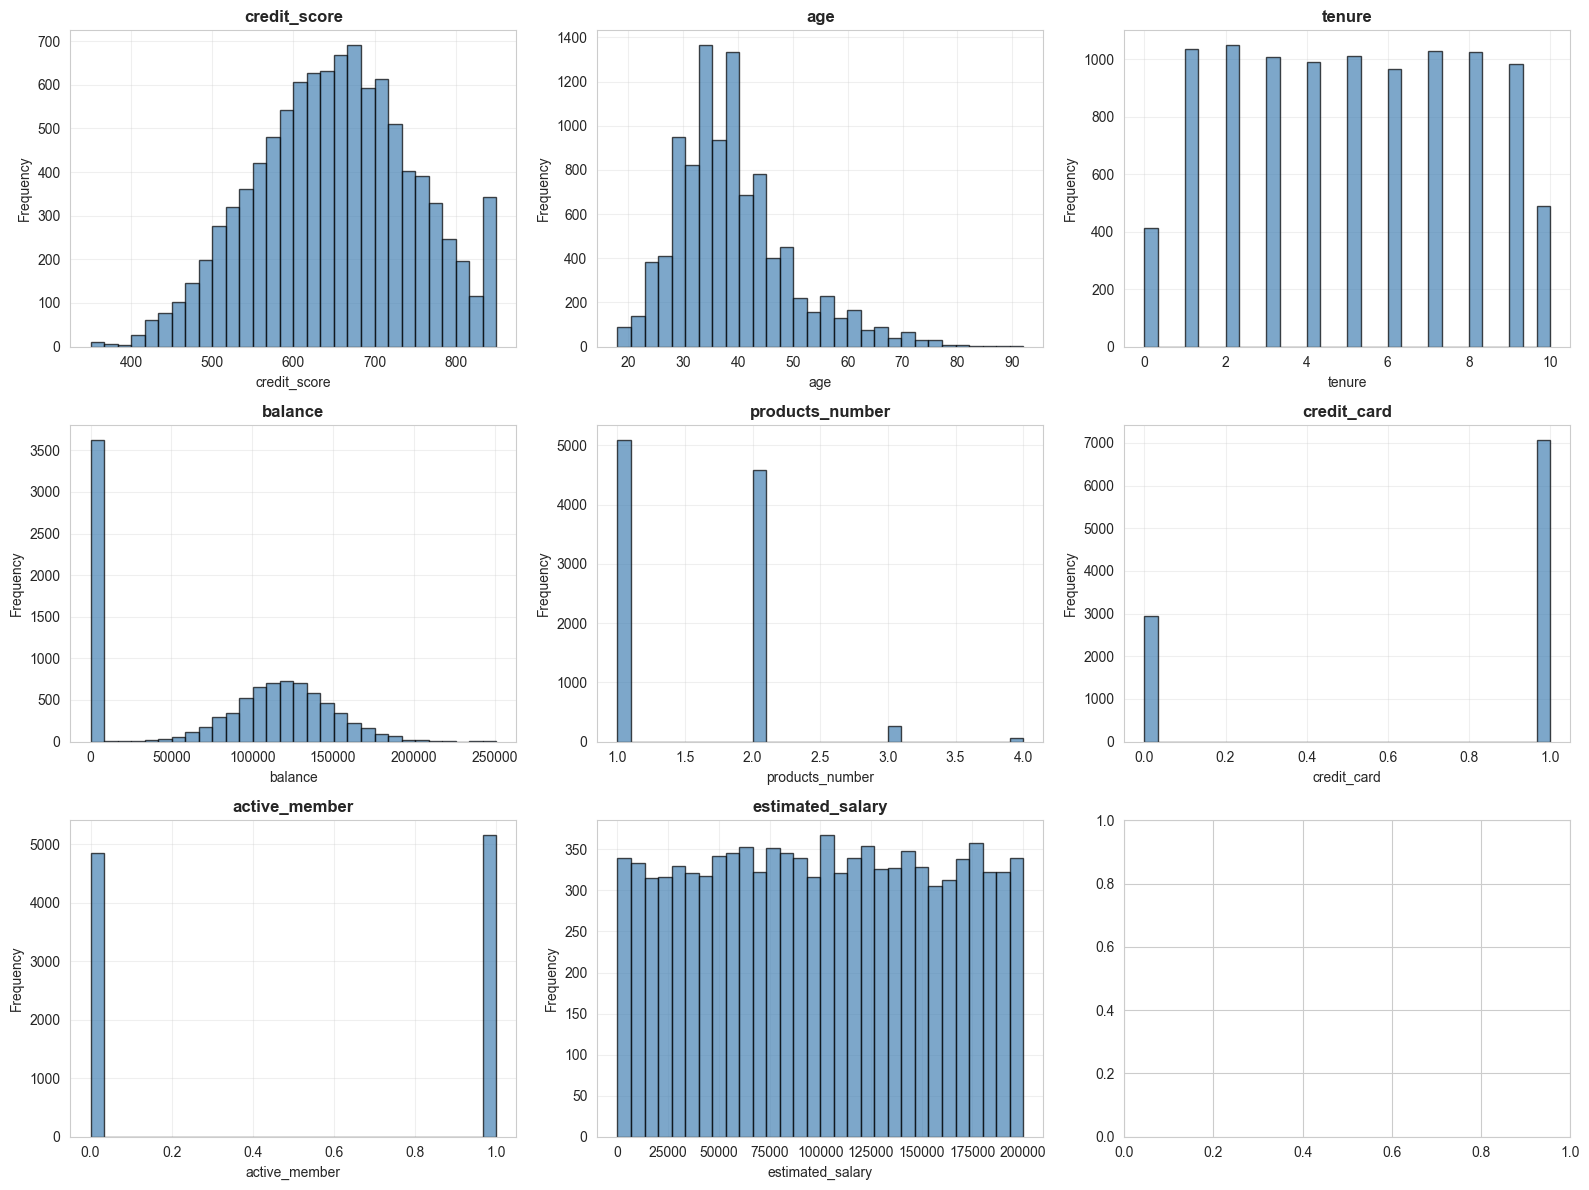

In [12]:
# Relevant numerical features (excluding customer_id and churn)
num_features = [col for col in numerical_cols if col not in ['customer_id', 'churn']]

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for idx, col in enumerate(num_features):
    axes[idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Categorical Features Analysis

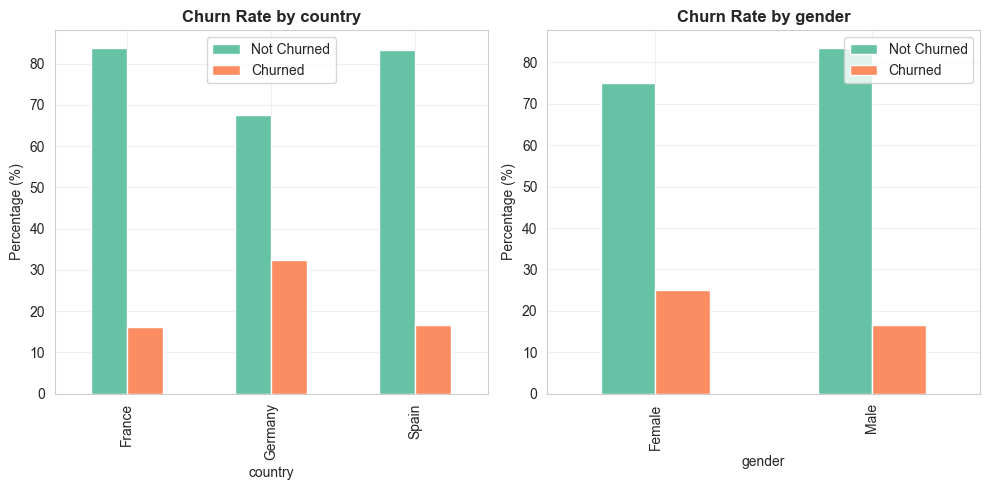

In [13]:
cat_features = [col for col in categorical_cols if col != 'customer_id']

if len(cat_features) > 0:
    fig, axes = plt.subplots(1, len(cat_features), figsize=(5*len(cat_features), 5))
    if len(cat_features) == 1:
        axes = [axes]
    
    for idx, col in enumerate(cat_features):
        churn_by_cat = pd.crosstab(df[col], df['churn'], normalize='index') * 100
        churn_by_cat.plot(kind='bar', ax=axes[idx], color=['#66c2a5', '#fc8d62'])
        axes[idx].set_title(f'Churn Rate by {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Percentage (%)')
        axes[idx].legend(['Not Churned', 'Churned'])
        axes[idx].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Correlation Analysis

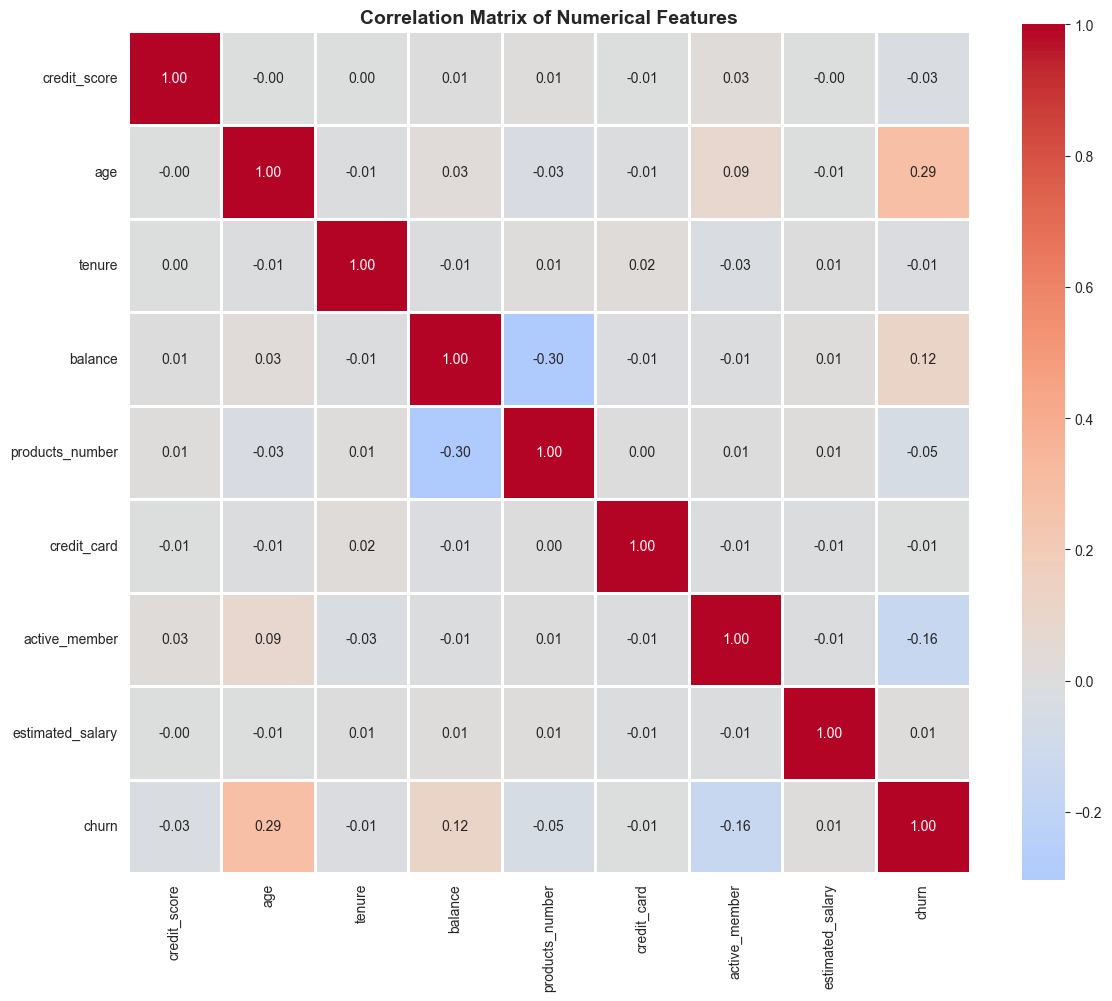


Features correlation with Churn:
churn               1.000000
age                 0.285323
balance             0.118533
estimated_salary    0.012097
credit_card        -0.007138
tenure             -0.014001
credit_score       -0.027094
products_number    -0.047820
active_member      -0.156128
Name: churn, dtype: float64


In [14]:
# Correlation matrix
corr_matrix = df[numerical_cols].corr()

# Visualization
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Features most correlated with churn
print("\nFeatures correlation with Churn:")
churn_corr = corr_matrix['churn'].sort_values(ascending=False)
print(churn_corr)

### Numerical Features vs Churn

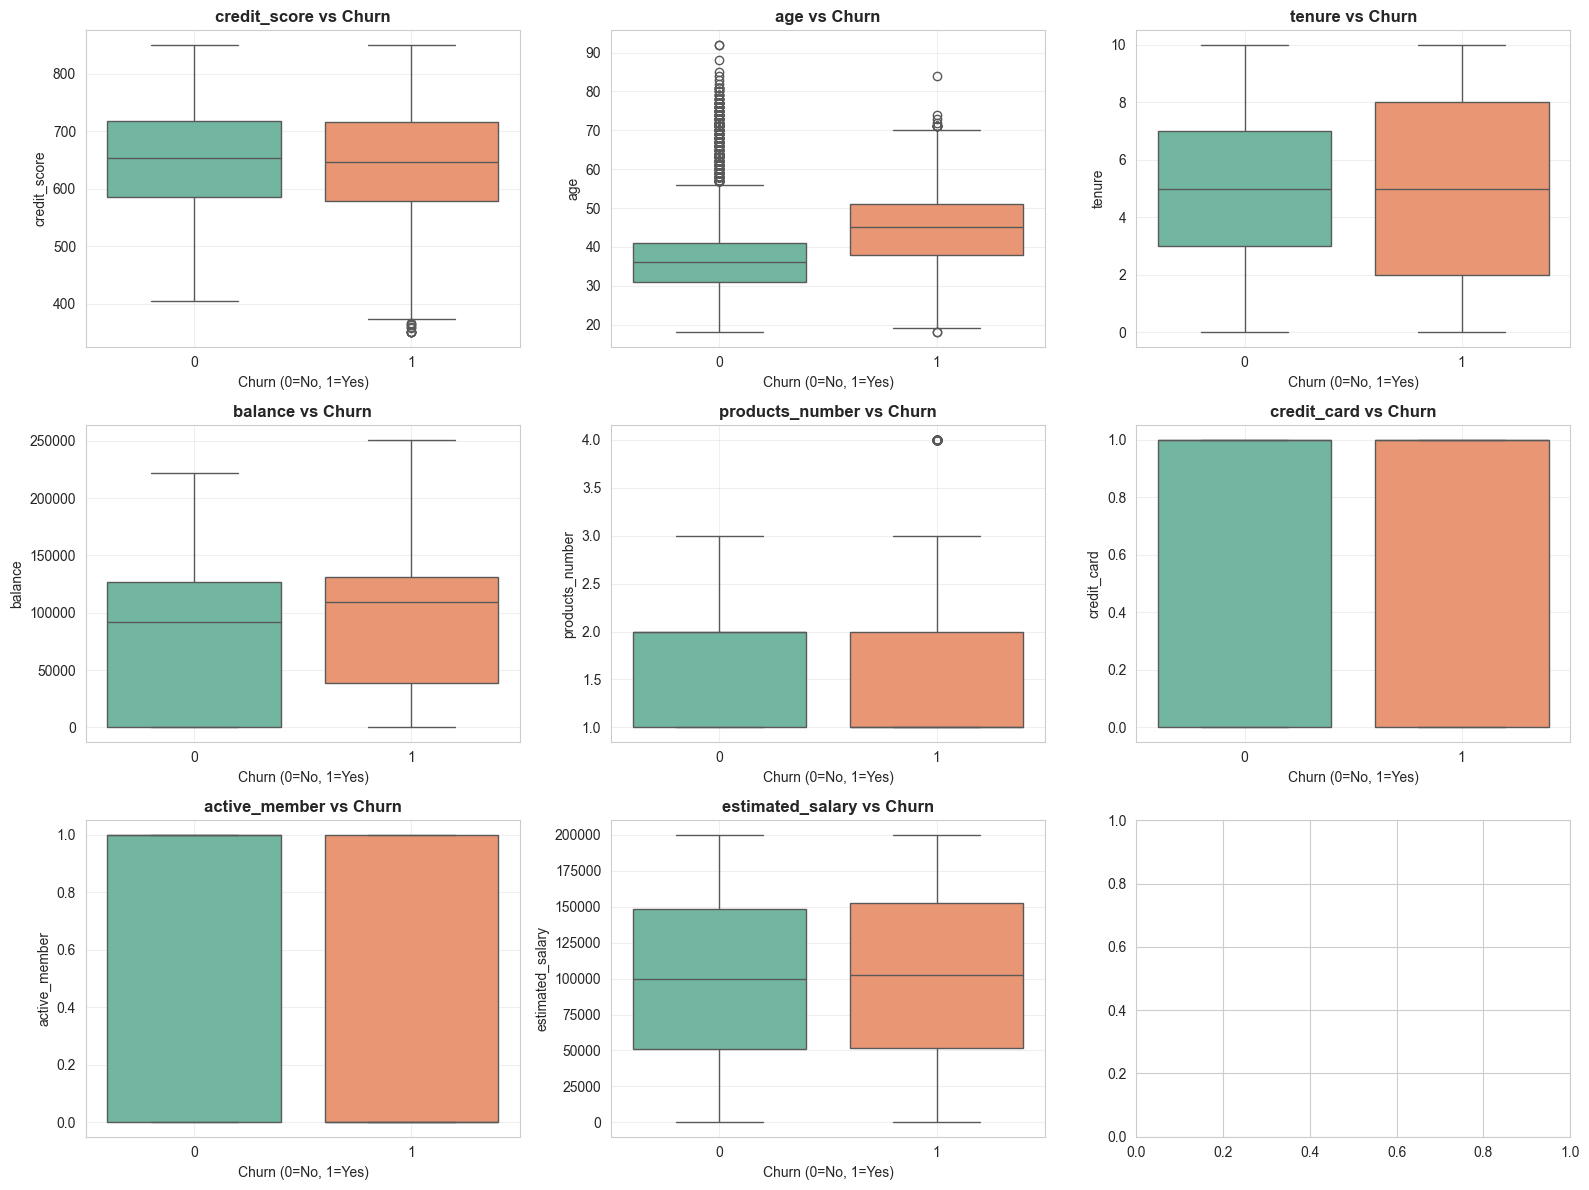

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for idx, col in enumerate(num_features):
    sns.boxplot(data=df, x='churn', y=col, ax=axes[idx], palette='Set2')
    axes[idx].set_title(f'{col} vs Churn', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Churn (0=No, 1=Yes)')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Key Insights Summary

We observe a class imbalance (20.37% churners). This requires special handling during preprocessing, as standard models might be biased towards the majority class

In [16]:
print(f"""
1. Dataset Size: {df.shape[0]} customers with {df.shape[1]} features

2. Target Variable (Churn):
   - Churned customers: {churn_percentage[1]:.2f}%
   - Not churned: {churn_percentage[0]:.2f}%
   - Class imbalance: {'Yes' if churn_percentage[1] < 30 or churn_percentage[1] > 70 else 'Moderate'}

3. Missing Values: {'None' if missing_df['Missing Count'].sum() == 0 else 'Present'}

4. Feature Types:
   - Numerical: {len(num_features)}
   - Categorical: {len(cat_features)}

5. Top 3 Features Correlated with Churn:
{churn_corr[1:4]}
""")


1. Dataset Size: 10000 customers with 12 features

2. Target Variable (Churn):
   - Churned customers: 20.37%
   - Not churned: 79.63%
   - Class imbalance: Yes

3. Missing Values: None

4. Feature Types:
   - Numerical: 8
   - Categorical: 2

5. Top 3 Features Correlated with Churn:
age                 0.285323
balance             0.118533
estimated_salary    0.012097
Name: churn, dtype: float64

